# Data Mining and Exploration [INFR11007]

# Lab 3: Unsupervised dimensionality reduction

In this lab we look at various unsupervised dimensionality reduction methods. By reducing the dimensionality to two or three dimensions only, we can visualise the data e.g. by scatter plots.

When we deal with labeled data, we hope that in the low-dimensional space the classes are well-separated, that is, the transformed low-dimensional data form clusters which corresond to the different classes.

Similar to Lab 1, we make use of the [landsat satellite](https://archive.ics.uci.edu/ml/datasets/Statlog+%28Landsat+Satellite%29) dataset which is 36-dimensional and comprises 6 classes.

As always, we first need to import the required python packages.

In [1]:
# Import required packages 
from __future__ import division, print_function
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn import manifold
from ppca import PPCA
%matplotlib inline

ImportError: No module named ppca

### ========== Question 1 ==========
Load the `landsat_train.csv` dataset into a `pandas` DataFrame called  `landsat_train` and display the shape of the DataFrame.

In [3]:
# Your code goes here
path_train = os.path.join(os.getcwd(), 'datasets', 'landsat', 'landsat_train.csv')
landsat_train = pd.read_csv(path_train, delimiter = ',')
print("There are {} entries and {} columns in the landsat_train DataFrame"\
      .format(landsat_train.shape[0], landsat_train.shape[1]))

There are 4435 entries and 37 columns in the landsat_train DataFrame


### ========== Question 2 ==========
Load the dataset class names into a DataFrame called `landsat_labels`.  By using the `to_dict()` method convert this DataFrame into a single dictionary. Alternatively, you can make use of  the `DictReader()` function which should be loaded from the `csv` module. There is also the option to use `numpy's` `genfromtxt()` function. You are free to choose the method that suits you best, but you should inspect the final dictionary to make sure it looks as expected.

In [4]:
# Your code goes here
# By using pandas
labels_path = os.path.join(os.getcwd(), 'datasets', 'landsat', 'landsat_classes.csv')
landsat_labels = pd.read_csv(labels_path, delimiter = ',', index_col=0)
landsat_labels_dict = landsat_labels.to_dict()["Class"]
print(landsat_labels_dict)

{1: 'red soil', 2: 'cotton crop', 3: 'grey soil', 4: 'damp grey soil', 5: 'soil with vegetation stubble', 6: 'mixture class (all types present)', 7: 'very damp grey soil'}


In [5]:
# Alternatively, by using DictReader()
import csv
labels_path = os.path.join(os.getcwd(), 'datasets', 'landsat', 'landsat_classes.csv')
reader = csv.DictReader(open(labels_path))
landsat_labels_dict = {}
for row in reader:
    row_values_list = list(row.values())
    landsat_labels_dict[int(row_values_list[0])] = row_values_list[1]
print(landsat_labels_dict)

{1: 'red soil', 2: 'cotton crop', 3: 'grey soil', 4: 'damp grey soil', 5: 'soil with vegetation stubble', 6: 'mixture class (all types present)', 7: 'very damp grey soil'}


In [6]:
# By using numpy genfromtxt
labels_path = os.path.join(os.getcwd(), 'datasets', 'landsat', 'landsat_classes.csv')
key_value = np.genfromtxt(labels_path, delimiter=",", dtype=None, skip_header=1)
landsat_labels_dict = { k:v for k,v in key_value }
print(landsat_labels_dict)

{1: 'red soil', 2: 'cotton crop', 3: 'grey soil', 4: 'damp grey soil', 5: 'soil with vegetation stubble', 6: 'mixture class (all types present)', 7: 'very damp grey soil'}


Now we want to replace the label numbers in the `landsat_train` DataFrame with the corresponding class names. We can achieve that by using the `pandas` function `replace()`. The `inplace` argument determines whether the method alters the object it is called upon and returns nothing, or returns a new object (when `inplace` is set to `False`).  

Execute the cell below which performs this replacement. The second line is used to show a random sample of 5 entries of the DataFrame for us to inspect the outcome of this transformation.

In [7]:
# Replace label numbers with their names
landsat_train.replace({'label' : landsat_labels_dict}, inplace=True)
landsat_train.sample(n=5, random_state=10)

,pixel_1_1,pixel_1_2,pixel_1_3,pixel_1_4,pixel_2_1,pixel_2_2,pixel_2_3,pixel_2_4,pixel_3_1,pixel_3_2,...,pixel_7_4,pixel_8_1,pixel_8_2,pixel_8_3,pixel_8_4,pixel_9_1,pixel_9_2,pixel_9_3,pixel_9_4,label
2893,67,81,86,64,67,81,82,64,67,77,...,65,68,77,86,65,72,81,86,68,very damp grey soil
43,80,94,102,83,76,89,98,79,68,77,...,83,79,91,104,79,75,79,96,79,soil with vegetation stubble
942,46,32,133,136,46,32,133,136,46,32,...,140,44,34,129,140,44,34,124,136,cotton crop
349,89,102,110,87,93,106,114,90,93,111,...,88,88,107,118,88,88,107,113,88,grey soil
4204,49,77,93,75,46,66,86,72,49,70,...,76,50,73,90,76,50,73,94,79,red soil


Now, we would like to separate the input features from the labels and store them into two `numpy` arrays. 

We will need two things:
* the `pandas` `drop()`  can be used to discard a specified axis in a DataFrame. We will use it to drop the `label` column.
* the `values` attribute of a DataFrame contains all valus in a `numpy array` format.

In [8]:
X = landsat_train.drop('label', axis=1).values # Input features
y = landsat_train['label'].values # Labels
print('Dimensionality of X: {}\nDimensionality of y: {}'.format(X.shape, y.shape))

Dimensionality of X: (4435, 36)
Dimensionality of y: (4435,)


## General note on scikit-learn methods

All supervised estimators in scikit-learn implement a `fit(X, y)` method which can be used fit the model, and a `predict(X)` method that, given unlabeled observations `X`, returns the predicted labels `y`.

Unsupervised methods and transformations still implement `fit(X)` but not `predict(X)`. Instead, they implement a `transform(X)` method which can be called once a model has been fit to transform the data in `X`. Most often, these two steps can be combined together by using the `fit_transform(X)` method when available.

### ========== Question 3 ==========

Display the means and standard deviations of the first 4 columns of `X`. *Hint: you want to compute the means and standard deviations across the columns of your arrays. Make sure you make appropriate use of the `axis` parameter.*

In [9]:
# Your code goes here
print('Mean of the first 4 columns in X: \n{}'.format(X.mean(axis=0)[0:4]))
print('Standard deviation of the first 4 columns in X: \n{}'.format(X.std(axis=0)[0:4]))

Mean of the first 4 columns in X: 
[ 69.47395716  83.85524239  99.32288613  82.55558061]
Standard deviation of the first 4 columns in X: 
[ 13.64809572  22.72251646  16.67028645  18.69334235]


## Data pre-processing: feature standardisation


**Feature standardisation** is a pre-processing technique used to transform data so that they have zero mean and unit standard deviation. For many algorithms, this is a very important step for training models (both regression and classification). Read about feature standardisation in the lecture notes and [here](http://scikit-learn.org/stable/modules/preprocessing.html) and make sure you understand what kind of transformation this method applies to the data.

As you might expect, scikit-learn offers an [implementation](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) of feature standardisation. 

### ========== Question 4 ========== 

Create a `StandardScaler` and fit it by using `X`. Then transform the array by using the scaler you just fit and save the results in a new array `X_sc`.

Finally, display the means and standard deviations of the first 4 columns of `X_sc`. Do the look as expected?

**For the rest of this lab you should use the standardised data (i.e. `X_sc`), unless you are explicitly asked to do otherwise.**

In [10]:
from sklearn.preprocessing import StandardScaler
# Your code goes here
X_sc = StandardScaler().fit_transform(X.astype(np.float))
print('Mean of the first 4 columns in X_sc: \n{}'.format(X_sc.mean(axis=0)[0:4]))
print('Standard deviation of the first 4 columns in X_sc: \n{}'.format(X_sc.std(axis=0)[0:4]))

Mean of the first 4 columns in X_sc: 
[  4.35778183e-16   1.53804065e-16  -1.05740294e-16  -1.92255081e-16]
Standard deviation of the first 4 columns in X_sc: 
[ 1.  1.  1.  1.]


*Your answer goes here*

Results look as expected, features have now zero mean and unit standard deviation.

## Visualisation

In this lab we will be using various dimensionality reduction methods and visualise their outputs in 2D space by using scatter plots. For this, we provide a function `scatter_2d_label()` which creates a scatter plot of 2D data and also annotates the corresponding classes appropriately. Execute the following cell and make sure you understand what this function does.

In [11]:
def scatter_2d_label(X_2d, y, s=2, alpha=0.5, lw=2):
    """Visualuse a 2D embedding with corresponding labels.
    
    X_2d : ndarray, shape (n_samples,2)
        Low-dimensional feature representation.
    
    y : ndarray, shape (n_samples,)
        Labels corresponding to the entries in X_2d.
        
    s : float
        Marker size for scatter plot.
    
    alpha : float
        Transparency for scatter plot.
        
    lw : float
        Linewidth for scatter plot.
    """
    targets = np.unique(y)
    colors = sns.color_palette(n_colors=targets.size)
    for color, target in zip(colors, targets):
        plt.scatter(X_2d[y == target, 0], X_2d[y == target, 1], color=color, label=target, s=s, alpha=alpha, lw=lw)

The following cell selects two columns of `X_sc` (i.e. features in the high-dimensional space) and uses the `scatter_2d_label()` function provided above to visualise the 2D scatter plots. Feel free to experiment with different selections of dimensions.

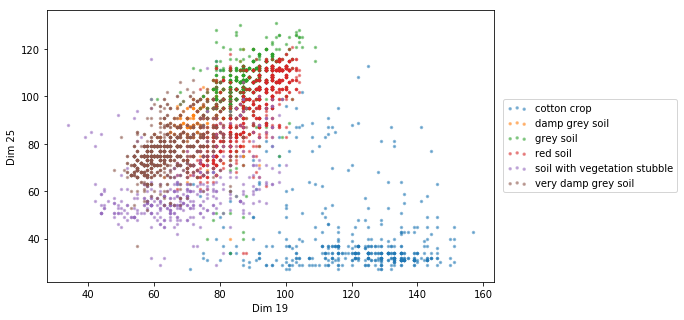

In [12]:
dim_1 = 19 # First dimension
dim_2 = 25 # Second dimension
plt.figure(figsize=(8,5)) # Initialise a figure instance with defined size
scatter_2d_label(X[:, [dim_1,dim_2]], y)
plt.legend(loc='center left', bbox_to_anchor=[1.01, 0.5], scatterpoints=3) # Add a legend outside the plot at specified point
plt.xlabel('Dim {}'.format(dim_1))
plt.ylabel('Dim {}'.format(dim_2))
plt.show()

### ========== Question 5 ========== 
Take a random 2D projection of the data by using all the original features and observe the 2D scatter plot in the embedded space. Do you observe any clusters?  

*Hint: set the `random_seed` parameter to an integer of your choice to ensure reproducible results.*

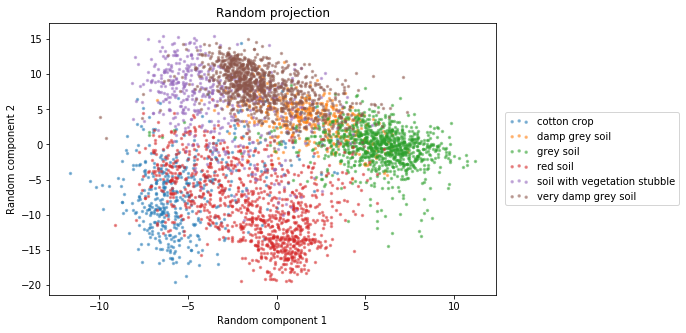

In [13]:
# Your code goes here
np.random.seed(seed=20) # Ensure reproducible results
random_weights = np.random.randn(X.shape[1], 2)
X_rnd_proj = np.dot(X_sc, random_weights)
plt.figure(figsize=(8,5))
scatter_2d_label(X_rnd_proj, y)
plt.legend(loc='center left', bbox_to_anchor=[1.01, 0.5], scatterpoints=3)
plt.xlabel('Random component 1')
plt.ylabel('Random component 2')
plt.title('Random projection')
plt.show()

*Your answer goes here*

Depending on how we set the random seed, we might or might not observe  clusters. Even if we do, the likelihood that these are well-separated is very small (unless we are extremely lucky!)

##  Principal component analysis (PCA)

In Lab 2, we saw how to implement principal component analysis (PCA). In this lab, we will use the [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) module in scikit-learn for dimensionality reduction. The cell below computes the PC scores from the (standardised) input data and makes use of the `scatter_2d_label()` function to visualise the outcome. Execute it and observe the outcome.

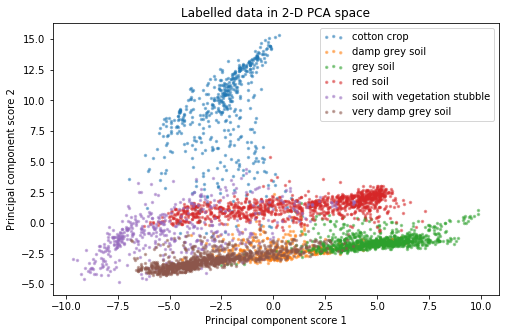

In [14]:
from sklearn.decomposition import PCA # Import the PCA module
X_pca_2d = PCA(n_components=2).fit_transform(X_sc) # Initialise a PCA instance, fit it by using X_sc and then transform X_sc
plt.figure(figsize=(8,5))
scatter_2d_label(X_pca_2d, y)
plt.title('Labelled data in 2-D PCA space')
plt.xlabel('Principal component score 1')
plt.ylabel('Principal component score 2')
plt.legend(loc='best', scatterpoints=3) # Ask matplotlib to place the legend where it thinks best
plt.show()

## Probabilistic principal component analysis (PPCA)

Probabilistic PCA will give very similar results to this, but it has the advantage that it can handle missing data. Before we see how that works, let's first implement the maximum likelihood solution for the parameters **W** and $\alpha$ as in the lectures notes. Remember that we can write them as:
$$\mathbf{W}_{ML} = \mathbf{U}_k(\mathbf\Lambda_k-\sigma^2 \mathbf{I})^{1/2}$$ 
$$\sigma_{ML}^2 = \frac{1}{d-k}\sum_{k+1}^{d}\lambda_i$$
where $\mathbf{U}_k$ contains the k principal eigenvectors of the sample covariance matrix, $\mathbf\Lambda_k$ is the diagonal matrix with the corresponding eigenvalues ($\lambda_1 \geq \lambda_2 \geq ... \geq \lambda_k $), $k$ is the number of principal components, $d$ is the dimension of the data. I omitted the $\mathbf{R}$ matrix from the formula in the lecture notes because we can set it to the identity matrix $\mathbf{I}$.

### ========== Question 6 ==========  

Write code that computes the parameters for the scaled data and 2 principal components, following these steps:

1. Find the eigenvectors and eigenvalues of the `sample covariance matrix`.
2. Sort them in descending order and pick the first $\mathbf{k}$.
3. Computer $\sigma_{ML}$ and use the result to get $\mathbf{W}_{ML}$.
4. Verify your result for $\sigma_{ML}$ using the `noise_variance_` attribute provided by the PCA module in scikit-learn.

You can use the `sort_eigvals_eigvec()` method from Lab 2 to sort the eigenvectors and eigenvalues.

In [15]:
def sort_eigvals_eigvec(eigvals, eigvecs):
    """Sorts eigenvalues and eigenvectors 
    in eigenvalue descending order."""
    order = np.argsort(eigvals)[::-1]
    eigvals_sorted = eigvals[order]
    eigvecs_sorted = eigvecs[:,order]
    return eigvals_sorted, eigvecs_sorted

In [16]:
# Your code goes here

C_sc_est = np.cov(X_sc, rowvar=False) # compute the covariance matrix
eigvals, eigvecs = np.linalg.eigh(C_sc_est) # compute the eigenvalues and eigenvectors
eigvals_sorted, eigvecs_sorted = sort_eigvals_eigvec(eigvals, eigvecs) # sort them

d = X_sc.shape[1]
s_ml = 1/(d-2) * np.sum(eigvals_sorted[2:])

u_k = eigvecs_sorted[:,:2]
l_k = np.diag(eigvals_sorted[:2])
w_ml = np.matrix(u_k) * (l_k - s_ml* np.identity(2))**(0.5)

pca = PCA(n_components=2).fit(X_sc)
noise_var = pca.noise_variance_
print("%.10f, %.10f" %(noise_var, s_ml))

0.1598959858, 0.1598959858


### ========== Question 7 ==========  

Inspect the first few rows of the components matrix for PCA and PPCA. Then compare the 2 matrices by computing the angle between the two spaces spanned by the coefficient vectors. For this you can use the `subspace_angles` method from the scipy library. Choose the first value from the vector array and transform it to degrees using the `rad2deg` method. If you computed the matrix correctly, the angle will be small. 

In [17]:
# Your code goes here
from scipy.linalg import subspace_angles

print("The first 5 entries of the 2 PCA components are: \n", pca.components_.T[:5,:])
print("The first 5 entries of the 2 PPCA components are: \n", w_ml[:5,:])
principal_angle = np.rad2deg(subspace_angles(w_ml,pca.components_.T)[0])
print("The principal angle between the two spaces is :", principal_angle)

ImportError: cannot import name subspace_angles

### Expectation Maximisation for PPCA

An alternative way to estimate the parameters is by using the expectation-maximisation (EM) approach. It has the added benefit of dealing with missing data while preserving the salient features of the projection.

The EM approach is used to approximate parameters in an iterative way. First the parameters are initiliased with random values. In the E-step the expectation of the log-likelihood of the model is computed based on the curent values of the parameters. In the M-step the parameters are re-estimated to maximise the log likelihood.

In the case of PPCA we are working with the expectation of the log likelihood of the complete-data (observations together with latent variables) with respect to the distributions $\textit{p}$ (observed data | latent variables, **W** and $\alpha$).

To see how this translates to EM steps, let us denote the observed data by $\{\mathbf{X}\}$, with the i-th row denoted by $\{\mathbf{x_i}\}$ and sample mean by $\mathbf{\overline{x}}$  and the latent variables by $\{\mathbf{Z}\}$ and similarly the i-th row by $\{\mathbf{z_i}\}$.

In the E-step we use the current parameter values for **W** and $\alpha$ to find:
$$\mathop{\mathbb{E}} [ \mathbf{z_i} ] = \mathbf{M}^{-1}\mathbf{W}^{T} ( \mathbf{x_i} - \mathbf{\overline{x}} ) $$
$$\mathop{\mathbb{E}} [ \mathbf{z_i} \mathbf{z_i}^T] = \sigma^2\mathbf{M}^{-1} + \mathop{\mathbb{E}} [ \mathbf{z_i} ] \mathop{\mathbb{E}} [ \mathbf{z_i} ]^T,  $$

where $\mathbf{M} = \mathbf{W}^T\mathbf{W} + \sigma \mathbf{I}$.

In the M-step we compute new values for **W** and $\alpha$:
$$\mathbf{W}_{new} = \Bigg[ \sum_{i=1}^{n}( \mathbf{x_i} - \mathbf{\overline{x}} )\mathop{\mathbb{E}} [ \mathbf{z_i} ]^{T} \Bigg] \Bigg[ \sum_{i=1}^{n} \mathop{\mathbb{E}} [ \mathbf{z_n} \mathbf{z_i}^T] \Bigg]^{-1} $$
$$\sigma^{2}_{new} = \frac{1}{nd} \sum_{i=1}^{n} \big\{||\mathbf{x}_i-\mathbf{\overline{x}}||^2 - 2\mathop{\mathbb{E}} [ \mathbf{z_i} ]^{T}\mathbf{W}_{new}^T( \mathbf{x_i} - \mathbf{\overline{x}} ) + trace(\mathop{\mathbb{E}} [ \mathbf{z_i} \mathbf{z_i}^T]\mathbf{W}_{new}^T\mathbf{W}_{new})\big\}. $$

The two steps are computed alternately until convergence.

<sub>To see a more detailed explanation of this approach refer to Chapter 12.2.2 of the book Pattern Recognition and Machine Learning by Christopher M. Bishop.</sub> 

We will visualise how PPCA with the EM approach behaves in the case of missing data. Run the following cell to create a new dataset with a given percentage of missing values. 

In [ ]:
def remove_percentage_data(data,percentage):

    N = X_sc.shape[0]
    d = X_sc.shape[1]
    
    to_remove = int(percentage*N*d/100)
    
    data_missing= np.empty([N, d])
    data_missing[:] = X_sc[:]
    
    removed = []
    
    while to_remove>=0:
        i = random.randint(0, N-1)
        j = random.randint(0, d-1)
        while (i,j) in removed:
            i = random.randint(0, N-1)
            j = random.randint(0, d-1)
        data_missing[i,j] = np.NaN
        removed.append((i,j))
        to_remove -= 1

    return data_missing

percentage = 10
data_missing = remove_percentage_data(X_sc,percentage)

### ========== Question 8 ==========  

The following cell computes the PC directions and scores for the complete dataset using PCA and EM-PPCA and for the incomplete dataset with EM-PPCA. Use the results to visualise the PC scores for the 3 cases. The plots you initially obtain might need to be rotated. For this use one of the `change_sign` methods. 

In [ ]:
# PCA for the entire dataset
pca = PCA(n_components=2).fit(X_sc)
scores_pca = pca.transform(X_sc)

# PPCA for the entire dataset
ppca_all_data = PPCA()
ppca_all_data.fit(X_sc,d=2)
scores_all= ppca_all_data.transform()

# PPCA for the dataset with missing values
ppca_missing_data = PPCA()
ppca_missing_data.fit(data_missing,d=2)
scores_missing = ppca_missing_data.transform()

In [ ]:
# Make reflections 

def change_sign_x(m):
    return np.array([[-a, b] for [a,b] in m])

def change_sign_y(m):
    return np.array([[a, -b] for [a,b] in m])

In [ ]:
# Your code goes here

fig = plt.figure(figsize=(20,5))

ax1 = fig.add_subplot(131)
scatter_2d_label(scores_pca, y)
ax1.set_title('PCA')
ax1.set_xlabel('Principal component score 1')
ax1.set_ylabel('Principal component score 2')

# Choose one of the options below, depending on which reflection you need to do.
# If no reflection is needed choose the first option.

ax2 = fig.add_subplot(132)
ax2.set_title('PPCA')
ax2.set_xlabel('Principal component score 1')
ax2.set_ylabel('Principal component score 2')
#scores_missing_reflect = scores_missing[:]
#scores_missing_reflect = change_sign_x(scores_missing)
#scores_missing_reflect = change_sign_y(scores_missing)
scores_missing_reflect = change_sign_x(change_sign_y(scores_missing))
scatter_2d_label(scores_missing_reflect, y)

ax3 = fig.add_subplot(133)
ax3.set_title('PPCA (missing data)')
ax3.set_xlabel('Principal component score 1')
ax3.set_ylabel('Principal component score 2')
#scores_all_reflect = scores_all[:]
scores_all_reflect = change_sign_x(scores_all)
#scores_all_reflect = change_sign_y(scores_all)
#scores_all_reflect = change_sign_x(change_sign_y(scores_all))
scatter_2d_label(scores_all_reflect, y)

Additionally you can overlap the two plots for PPCA and PPCA with missing data to see the difference in the projections. Try it out with different percentages of missing data!

In [ ]:
# Your code goes here

fig = plt.figure(figsize=(8,8))
fig.suptitle("Projection data using PCA on the full dataset \n and on the dataset with %s%% missing data" %percentage, size = 12)
plt.scatter(scores_missing_reflect[:,0],scores_missing_reflect[:,1], alpha=0.5, s=20)
plt.scatter(scores_all_reflect[:,0],scores_all_reflect[:,1], alpha=0.5, s=20)
plt.xlabel('Principal component score 1')
plt.ylabel('Principal component score 2')
plt.show()

## Kernel density estimate (KDE) in embedded space
Some times we might want to describe the data in the embedded space in a slightly better way than with just a scatter plot. For instance, we might be interested in where the density is.

### ========== Question 9 ========== 
By using the `scatter_2d_label()` function as a template, write a new function `kde_2d_label()` which shows kernily density estimates for the data in the embedded space. Individual densities should be estimated for each class and they should be shown in different colours.

*Hint. You should make use of the seaborn function `kdeplot()`.*

Next, use the function you just wrote to visualise the kernel density estimates of the PC scores for each class. Do not worry about adding a legend in your plot at this point.

In [ ]:
# Your code goes here
def kde_2d_label(X_2d, y):
    """Kernel density estimate in a 2D embedding with corresponding labels.
    
    X_2d : ndarray, shape (n_samples,2)
        Low-dimensional feature representation.
    
    y : ndarray, shape (n_samples,)
        Labels correspodning to the entries in X_2d.
    """
    targets = np.unique(y)
    colors = sns.color_palette(n_colors=targets.size)
    for color, target in zip(colors, targets):
        sns.kdeplot(X_2d[y == target, 0], X_2d[y == target, 1], cmap=sns.dark_palette(color, as_cmap=True))

In [ ]:
# The following commands are used to create an appropriate legend for the superimposed KDE plots
import matplotlib.lines as mlines
cats = np.unique(y)
color_palette = sns.color_palette(n_colors=cats.size)
patches = [mlines.Line2D([], [], color=color_palette[ii], label=cat) for ii, cat in enumerate(cats)]

plt.figure(figsize=(8,5))
kde_2d_label(X_pca_2d, y)
plt.title('Kernel density estimation in PCA space')
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')
plt.legend(patches, cats, loc='center left', scatterpoints=3, bbox_to_anchor=[1.01, 0.5]) # Use the custom legend entries
plt.show()

## Kernel principal component analysis (KPCA)

PCA is a linear method, in the sense that the reduced dimension representation is generated by linear projections and this can severely limit the usefulness of the approach. Several versions of nonlinear PCA have been proposed in the hope of overcoming this problem. One such algorithm is kernel PCA.

Kernel PCA applies the kernel trick to create a nonlinear version of PCA in sample space by performing ordinary PCA in the augmented kernel space (cf Lab 2, eigendecomposition of Gram matrix, and the lecture notes on kernel PCA).

Scikit-learn offers an implentation of KPCA which supports the use of various kernels.  Familiarise yourself with this class by reading the [user guide](http://scikit-learn.org/stable/modules/decomposition.html#kernel-pca) and  [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html#sklearn.decomposition.KernelPCA).


### ========== Question 10 ========== 

By using the `KernelPCA` module, apply kernel PCA to the standardised data in `X_sc`. Set the `n_components` parameter to `2` and use default settings for other parameters. Experiment with different kernels. How do the results differ when different kernels are used?

In [ ]:
from sklearn.decomposition import KernelPCA

# Your code goes here

kernels = ['rbf', 'poly', 'cosine', 'sigmoid']

sns.set(font_scale=1.5)
fig, ax = plt.subplots(2,2,figsize=(12,10))
for ii, kernel in enumerate(kernels):
    X_kpca_2d = KernelPCA(n_components=2, kernel=kernel).fit_transform(X_sc)
    plt.subplot(2,2,ii+1)
    scatter_2d_label(X_kpca_2d, y)
    plt.title('{} kernel'.format(kernel))
    plt.xlabel('Principal component 1')
    plt.ylabel('Principal component 2')
plt.legend(loc='center left', bbox_to_anchor=[1.01, 1.], scatterpoints=3)
fig.tight_layout()
plt.show()

*Your answer here*

As expected, the selection of kernel dramatically affects the results of the method.

### ========== Question 11 [optional] ========== 

Apply PCA and kernel PCA by using an RBF kernel to:
1. the raw data in `X`
2. the standardised data in `X_sc`. 

What do you observe? Which case seems to be affected by feature standardisation? Can you explain why?

*Hint: Set the `n_components` parameter to `2` and use default settings for other parameters. *

In [ ]:
# Your code goes here
from itertools import product

methods = {"PCA" : PCA(n_components=2), "Kernel PCA (RBF)" : KernelPCA(n_components=2, kernel='rbf')}
datasets = {"Raw" : X, "Standardised" : X_sc}

sns.set(font_scale=1.)
fig, ax = plt.subplots(2,2,figsize=(12,10))

for ii, ((method_name, method), (data_name, data)) in enumerate(product(methods.items(), datasets.items())):
    X_2d = method.fit_transform(data)
    plt.subplot(2,2,ii+1)
    scatter_2d_label(X_2d, y)
    plt.title('{},  {} data'.format(method_name, data_name))
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
plt.legend(loc='center left', bbox_to_anchor=[1.01, 1.], scatterpoints=3)
plt.show()

*Your answer goes here*

As expected, both methods are affected by standardisation, but kernel PCA with RBF kernel is more heavily affected. This is somehow expected since the Gram matrix is more heavily sensitive to the scale of the features.

## Multidimensional scaling (MDS)

Multidimensional scaling (MDS) refers to a collection of techniques for dimensionality reduction that operate on dissimilarities. The goal of MDS is to find a configuration of points in the plane, or more generally the Euclidean space, so that their distances well represent the original dissimilarities.

We look here into metric MDS (see Section 3.3.1 in the lecture notes). Scikit-learn offers an implentation.  Familiarise yourself with this class by reading the [user guide](http://scikit-learn.org/stable/modules/manifold.html#multidimensional-scaling) and  [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.MDS.html).

### ========== Question 12 ========== 
Use the `MDS` module in scikit-learn to transform the standardised data by using metric MDS. Set `n_components` to `2`, `max_iter` to `100`, `n_init` to `1`, and use default settings for other parameters.  

Visualise the data by using the `scatter_2d_label()` function. What do you observe?

The code returns the value of the objective in (3.31), which is called the `stress_` score and corresponds to the quality of the lower dimensional representation (small values are better).

In [ ]:
# Your code goes here
from sklearn.manifold import MDS
sns.set(font_scale=1.)
mds = MDS(n_components=2, metric=True, n_init=1, max_iter=100, random_state=10)
X_mds_2d = mds.fit_transform(X_sc)
plt.figure(figsize=(8,5))
scatter_2d_label(X_mds_2d, y)
plt.title('Metric MDS, stress: {}'.format(mds.stress_))
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(loc='center left', bbox_to_anchor=[1.01, 0.5], scatterpoints=3)
plt.show()

*Your answer goes here*

It seems that metric MDS does a relatively good job in discovering structure in this dataset with the current configuration. We can, however, see a symmetry in the data, so that a third component might be needed for clear separation of the clusters (see below).

In [ ]:
def scatter_3d_label(X_3d, y, fig=None, s=2, alpha=0.5, lw=2):
    """Visualuse a 3D embedding with corresponding labels.
    
    X_3d : ndarray, shape (n_samples,3)
        Low-dimensional feature representation.
    
    y : ndarray, shape (n_samples,)
        Labels corresponding to the entries in X_3d.
        
    s : float
        Marker size for scatter plot.
    
    alpha : float
        Transparency for scatter plot.
        
    lw : float
        Linewidth for scatter plot.
    """
    from mpl_toolkits.mplot3d import Axes3D
    if fig is None:
        fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111, projection='3d')

    targets = np.unique(y)
    colors = sns.color_palette(n_colors=targets.size)
    for color, target in zip(colors, targets):
        ax.scatter(X_3d[y == target, 0], X_3d[y == target, 1], X_3d[y == target, 2], 
                    color=color, s=s, label=target, alpha=alpha, lw=lw)
    return (fig, ax)

In [ ]:
# Metric MDS with three componenets
mds_3_comp = MDS(n_components=3, metric=True, n_init=1, max_iter=100, random_state=10)
X_mds_3d = mds_3_comp.fit_transform(X_sc)

fig = plt.figure(figsize=(8,6))
_, ax = scatter_3d_label(X_mds_3d, y, fig=fig)
ax.set_xlabel('Dim 1')
ax.set_ylabel('Dim 2')
ax.set_zlabel('Dim 3')
ax.set_title('Labelled data with MDS (3 components)')
ax.legend(loc='center left', bbox_to_anchor=[1.01, 0.5], scatterpoints=3)
ax.azim = 400
ax.elev = 5
fig.tight_layout()
plt.show()

### ========== Question 13 [optional] ========== 
Observe the outcome of metric MDS by using a [cosine](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.pairwise_distances.html) distance this time.

Make sure you set the `dissimilarity` argument appropriately when you construct the `MDS` instance, and you pass the distance matrix when you call the `fit_transform()` method.

Feel free to experiment with other types of distances.

In [ ]:
from sklearn.metrics.pairwise import pairwise_distances
# Your code goes here
similarities = pairwise_distances(X=X_sc, metric='cosine')
sns.set(font_scale=1.)
plt.figure(figsize=(8,5))
mds = MDS(n_components=2, metric=True, dissimilarity='precomputed', n_init=1, max_iter=100)
X_mds_2d = mds.fit_transform(similarities)
scatter_2d_label(X_mds_2d, y)
plt.title('Metric MDS (cosine distance), stress: {}'.format(mds.stress_))
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(loc='center left', bbox_to_anchor=[1.01, 0.5], scatterpoints=3)
plt.show()

## Isomap
MDS does not attempt to explicitly model the underlying data manifold. Isomap, on the other hand, addresses the dimensionality reduction problem by doing so. Suppose your data lie on a curve, but the curve is not a straight line. The key assumption made by Isomap is that the quantity of interest, when comparing two points, is the distance along the curve between the two points. 

In other words, Isomap performs MDS in the geodesic space of the nonlinear data manifold. The geodesic distances represent the shortest paths along the curved surface of the manifold measured as if the surface was flat. This can be approximated by a sequence of short steps between neighbouring sample points. Isomap then applies MDS to the geodesic rather than straight line distances to find a low-dimensional mapping that preserves these pairwise distances.

To summarise, Isomap uses three steps:
1.  Find the neighbours of each data point in high-dimensional data
2.  Compute the geodesic pairwise distances between all points
3.  Embed the data via MDS so as to preserve these distances.


Familiarise yourself with the Isomap class in scikit-learn by reading the [user guide](http://scikit-learn.org/stable/modules/manifold.html#isomap) and  [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.Isomap.html).


### ========== Question 14  ========== 

Project the standardised data into a 2D space by using the Isomap algorithm. Set the `n_components` argument to 2 and explore the role of the `n_neighbours` parameter which defines how many neighbours are used in step 1 above. You can start by trying the following values, but feel free to experiment further: [1, 3, 5, 10, 50, 100]

Use default settings for other parameters.

In [ ]:
from sklearn.manifold import Isomap
# Your code goes here
sns.set(font_scale=1.5) # Set default font size
fig, ax = plt.subplots(3,2,figsize=(12,14))
for ii, n_neighbors in enumerate([1, 3, 5, 10, 50, 100]):
    ismp = Isomap(n_components=2, n_neighbors=n_neighbors)
    X_ismp_2d = ismp.fit_transform(X_sc)
    plt.subplot(3,2,ii+1)
    scatter_2d_label(X_ismp_2d, y)
    plt.title('{} neighbours'.format(n_neighbors))
    plt.xlabel('Component 1')
    plt.ylabel('Component 2 ')
plt.legend(loc='center left', bbox_to_anchor=[1.01, 1.5], scatterpoints=3)
fig.tight_layout()
plt.show()

##  t-distributed Stochastic Neighbor (t-SNE) Embedding

t-SNE is a very powerful tool to visualize high-dimensional data. It converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data. 

t-SNE converts affinities of data points to probabilities. The affinities in the original space are represented by Gaussian joint probabilities and the affinities in the embedded space are represented by Student’s t-distributions. The Kullback-Leibler (KL) divergence of the joint probabilities in the original space and the embedded space are minimized by gradient descent. Note that the KL divergence is not convex, i.e. multiple restarts with different initializations will end up in local minima of the KL divergence.

One disadvantage of t-SNE is that it is computationally expensive.  Furthermore, the setting of the various hyper-parameters dramatically affects the results. Considering on top that the algorithm itself is not deterministic, it is obvious that setting these hyper-parameters can be a tricky task.

The **perplexity** parameter is, in a sense, a guess about the number of close neighbors each point has. It is related to the number of nearest neighbors that is used in other manifold learning algorithms like Isomap. The original paper says *“The performance of SNE is fairly robust to changes in the perplexity, and typical values are between 5 and 50* but, as we will see, depending on the dataset, this parameter can dramatically affect the results.


### ========== Question 15  ========== 

Familiarise yourself with the t-SNE class in scikit-learn by reading the [user guide](http://scikit-learn.org/stable/modules/manifold.html#t-sne) and  [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html).

Apply t-SNE to the standardised data and explore the role of the `perplexity` input arugment. You can, but are not limited to, try the following values: [2, 5, 10, 30, 50, 100]. 

On top of each scatter plot, display the KL score achieved with each setting. *Hint: look into the `kl_divergence_` attribute of the model.*

What do you think would be a good selection for the perplexity parameter?  

How do you think the performance of t-SNE compares to that of the other methods? Is the distance between neighbouring clusters in the embedded space sensible?

*You will probably notice that your code takes a while to execute (approx. 2-3 mins).*

In [ ]:
from sklearn.manifold import TSNE
# Your code goes here
sns.set(font_scale=1.5) # Set default font size
fig, ax = plt.subplots(3,2,figsize=(12,14))
for ii, perplexity in enumerate([2, 5, 10, 30, 50, 100]):
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=10)
    X_tsne_2d = tsne.fit_transform(X_sc)
    plt.subplot(3,2,ii+1)
    scatter_2d_label(X_tsne_2d, y)
    plt.title('Perplexity: {}, KL-score: {}'.format(perplexity, tsne.kl_divergence_))
    plt.xlabel('Component 1')
    plt.ylabel('Component 2 ')
plt.legend(loc='center left', bbox_to_anchor=[1.01, 1.5], scatterpoints=3)
fig.tight_layout()
plt.show()

*Your answer goes here*

Any value between 30 and 100 for the perplexity parameter seems reasonable. 

Obviously, the clusters obtained with t-SNE are much more well-separated than those with the other algorithms. Note, that not a single cluster corresponds to one label, but we might have more clusters for the same label. This is not necessarily a bad thing.

The distance between neighbouring clusters in the embedded space is not very sensible with the current configuration. For instance with PCA, kernel PCA, MDS and Isomap, clusters for `grey soil`, `damp grey soil` and `very damp grey soil` were close to each other. This was not the case with t-SNE.

### Optional

The following webpage provides an excellent interactive introduction to t-SNE, feel free to check it out and experiment further with the various parameters of the algorithm. 

http://distill.pub/2016/misread-tsne/